In [1]:
from unet import *
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import torch 
import torch.nn as nn
import torch.optim as optim
from tqdm import trange
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
#import pandas as pd

In [2]:
Net = build_unet()
# check if CUDA is available, and set it as the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("==> Device: {}".format(device))

# move model to the device
Net.to(device)

# define loss function
# criterion = nn.L1Loss()
criterion = nn.MSELoss()

####### HYPERPARAMETERS #######

# learning rate = 10^-4
lr = 0.0001

# patch size
patch_size = 512

# define optimizer
optimizer = optim.Adam(Net.parameters(), lr=lr)

# batch size
batch_size = 1

# define number of epochs
n_epochs = 2

# keep track of the best validation loss
valid_loss_min = np.Inf

# number of epochs to wait before stopping
early_stopping = 5


##### LOSS  #######

# keep track of training and validation loss
train_loss = []
valid_loss = []

# initialize the early_stopping object
# early_stopping = EarlyStopping(patience=early_stopping, verbose=True)



==> Device: cuda


In [5]:
def random_crop(image, label, patch_size):
    """
    Crop a random patch from the image
    """
    # get the shape of the image
    h, w = image.shape[:2]

    # get the top left corner of the random crop
    x = np.random.randint(0, w - patch_size)
    y = np.random.randint(0, h - patch_size)

    # crop the image
    image = image[y:y + patch_size, x:x + patch_size]
    label = label[y:y + patch_size, x:x + patch_size]

    return image, label

['data_mini/short\\short_1.ARW', 'data_mini/short\\short_2.ARW', 'data_mini/short\\short_3.ARW']
['data_mini/long\\long_1.ARW', 'data_mini/long\\long_2.ARW', 'data_mini/long\\long_3.ARW']


  0%|          | 0/2 [00:00<?, ?it/s]C:\Users\Rico\.conda\envs\assignment3_cuda\lib\site-packages\torch\nn\modules\loss.py:530: UserWarning: Using a target size (torch.Size([1, 3, 512, 512])) that is different to the input size (torch.Size([1, 1, 512, 512])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 2/2 [00:28<00:00, 14.36s/it]


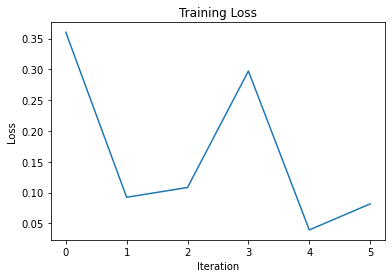

In [7]:
####### SAMPLE INPUT DATA #######
# labels_dir = '/home/deeplearning/images/SonyImages/Sony/long/'
# images_dir = '/home/deeplearning/images/SonyImages/Sony/short/'
#
# labels_dir = '/home/charles/Desktop/data/long/'
# images_dir = '/home/charles/Desktop/data/short/'

# images_dir = 'images/SonyImages/Sony/short/'
# labels_dir = 'images/SonyImages/Sony/long/'

images_dir = 'data_mini/short/'
labels_dir = 'data_mini/long/'

# read all images in the directories
images = glob.glob(images_dir + '*.ARW')
labels = glob.glob(labels_dir + '*.ARW')


# # sort the images and labels
images.sort()
labels.sort()

print(images)
print(labels)

# only train on 10 images, discard the rest
images = images[:10]
labels = labels[:10]

epoch_loss = 0

# loop over epochs with tqdm progress bar
t = trange(n_epochs, leave=True)
for epoch in t:
    # initialize the training and validation loss for this epoch
    train_loss_epoch = 0.0
    valid_loss_epoch = 0.0

    # set the model to training mode
    Net.train()

    # loop over the training data
    #### IMPORTANT ####
    # len(images) == 3, if we are in the small size, so perhaps we can
    # heuristically increase this in order to get better results
    # sinze now it's just 3 images per epoch
    for i in range(len(images)):
        # load the first image and label
        image = rawpy.imread(images[i])
        label = rawpy.imread(labels[i])

        # convert the image and label to numpy arrays
        image = image.postprocess(use_camera_wb=True, half_size=False, no_auto_bright=True, output_bps=16)
        label = label.postprocess(use_camera_wb=True, half_size=False, no_auto_bright=True, output_bps=16)

        # convert the image and label to float32 data type
        image = np.float32(image / 65535.0)
        label = np.float32(label / 65535.0)

        # crop the image and label to 512 x 512
        image, label = random_crop(image, label, patch_size)
        # display the image and label
        # plt.imshow(image)
        # plt.show()
        # plt.imshow(label)
        # plt.show()

        # display file name of label and input to check if they are correct
        # print("==> Label: {}".format(labels[i]))
        # print("==> Image: {}".format(images[i]))
        # print("==> Image shape: {}".format(image.shape))
        # print("==> Label shape: {}".format(label.shape))       


        # convert the image and label to tensors
        image = torch.from_numpy(np.expand_dims(np.transpose(image, (2, 0, 1)), axis=0))
        label = torch.from_numpy(np.expand_dims(np.transpose(label, (2, 0, 1)), axis=0))

        # move the image and label to the device
        image, label = image.to(device), label.to(device)

        # forward pass
        output = Net(image)

        # calculate the loss
        loss = criterion(output, label)

        # backward pass
        loss.backward()

        # update the weights
        optimizer.step()

        # clear the gradients
        optimizer.zero_grad()

        # print the loss
        # print("==> Loss: {}".format(loss.item()))
        epoch_loss = loss.item()

        # update the training loss
        train_loss_epoch += loss.item()

        # append loss to the list
        train_loss.append(loss.item())

        # if epoch > 0:
        #     # display the output images with opencv2 using normal color scheme
        #     output = output.cpu().detach().numpy()
        #     output = np.clip(output * 65535.0, 0, 65535.0).astype('uint16')
        #     output = np.transpose(output[0, :, :, :], (1, 2, 0))
        #     output = cv2.cvtColor(output, cv2.COLOR_RGB2BGR)
        #     cv2.imshow("output", output)
        #     # waifor 1 ms for key press
        #     cv2.waitKey(1)




# plot loss
plt.plot(train_loss)
plt.title("Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

# plot 